In [1]:
# Import the python packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score


In [2]:
# Importing data for analysis

bike = pd.read_csv('day.csv')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
bike.shape

(730, 16)

In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


# Basic data understanding
1. there is no column having null values, so we dont need to treat null values.
2. almost all the columns are of numeric type

In [5]:
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## Data exploration and preparation
 Will be following below steps
 1. Understand the data and values to understand if any data formating is needed
 2. Convert data to categorical if needed
 3. Analysing data pattern
 4. Finding Outliers and treating if needed
 5. Check multicolienerity among the independent variables and find the columns which can be removed.
 


### Understanding the data for individual columns and how they are related to each other

1. as per the problem statement, we need nod to get into details about individual date and its relation to the business, and it does not seems to be adding any value to our model. So we can drop column dteday.

2. After exploring data it is clear that we need to format below categorical variables to have proper meaningful values
A. mnth transform to month name MMM
B. weekday transform to weekday ddd
C. weathersit tramsform to 1:'good',2:'moderate',3:'bad',4:'severe'


3. We can remove the instant field as well as this is row number in the dataset.

4. casual & registered, actually are part of cnt, and we are interested in the count only, and we want to predict count. So casual and registered are not going to help in that, so we can remove these two fields as well.

In [6]:
# Checking the columns

bike.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

bike.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)

bike.mnth = bike.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

bike.weekday = bike.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})
bike.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [7]:
#creating copy of dataframe for data cleaning purpose

bike_clean = bike[['instant','dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum'
                     , 'windspeed','casual','registered','cnt']]
bike_clean.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [8]:
## As mentioned above in data understanding dropping the mentioned columns
# Droping instant column 
bike_clean.drop(['instant'], axis = 1, inplace = True)

# Dropping dteday
bike_clean.drop(['dteday'], axis = 1, inplace = True)

# Dropping casual and registered

bike_clean.drop(['casual'], axis = 1, inplace = True)
bike_clean.drop(['registered'], axis = 1, inplace = True)

In [9]:
#veiweing the data set after dropping columns
bike_clean.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600


In [10]:
#anlysis of correlation among the variables
bike_clean.shape

(730, 12)

In [11]:
bike_clean.corr()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
yr,1.000000,0.008195,-0.002945,0.048789,0.047215,-0.112547,-0.011624,0.569728
holiday,0.008195,1.000000,-0.252948,-0.028764,-0.032703,-0.015662,0.006257,-0.068764
workingday,-0.002945,-0.252948,1.000000,0.053470,0.052940,0.023202,-0.018666,0.062542
temp,0.048789,-0.028764,0.053470,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.047215,-0.032703,0.052940,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,-0.112547,-0.015662,0.023202,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.011624,0.006257,-0.018666,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.569728,-0.068764,0.062542,0.627044,0.630685,-0.098543,-0.235132,1.000000


In [12]:
#with above and based on data dictionary information it is very clear that temp and atemp are having similar data and also having
#very high colinearity, so this gives an indication that having both fields in the dataset is not going to help or add any value 

#Dropping one of them will not have any impact in analysis and model.

#dropping atemp column
bike_clean.drop(['atemp'], axis = 1, inplace = True)

In [13]:
bike_clean.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,jan,0,sat,0,moderate,14.110847,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,moderate,14.902598,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,good,8.050924,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,good,8.200000,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,good,9.305237,43.6957,12.522300,1600


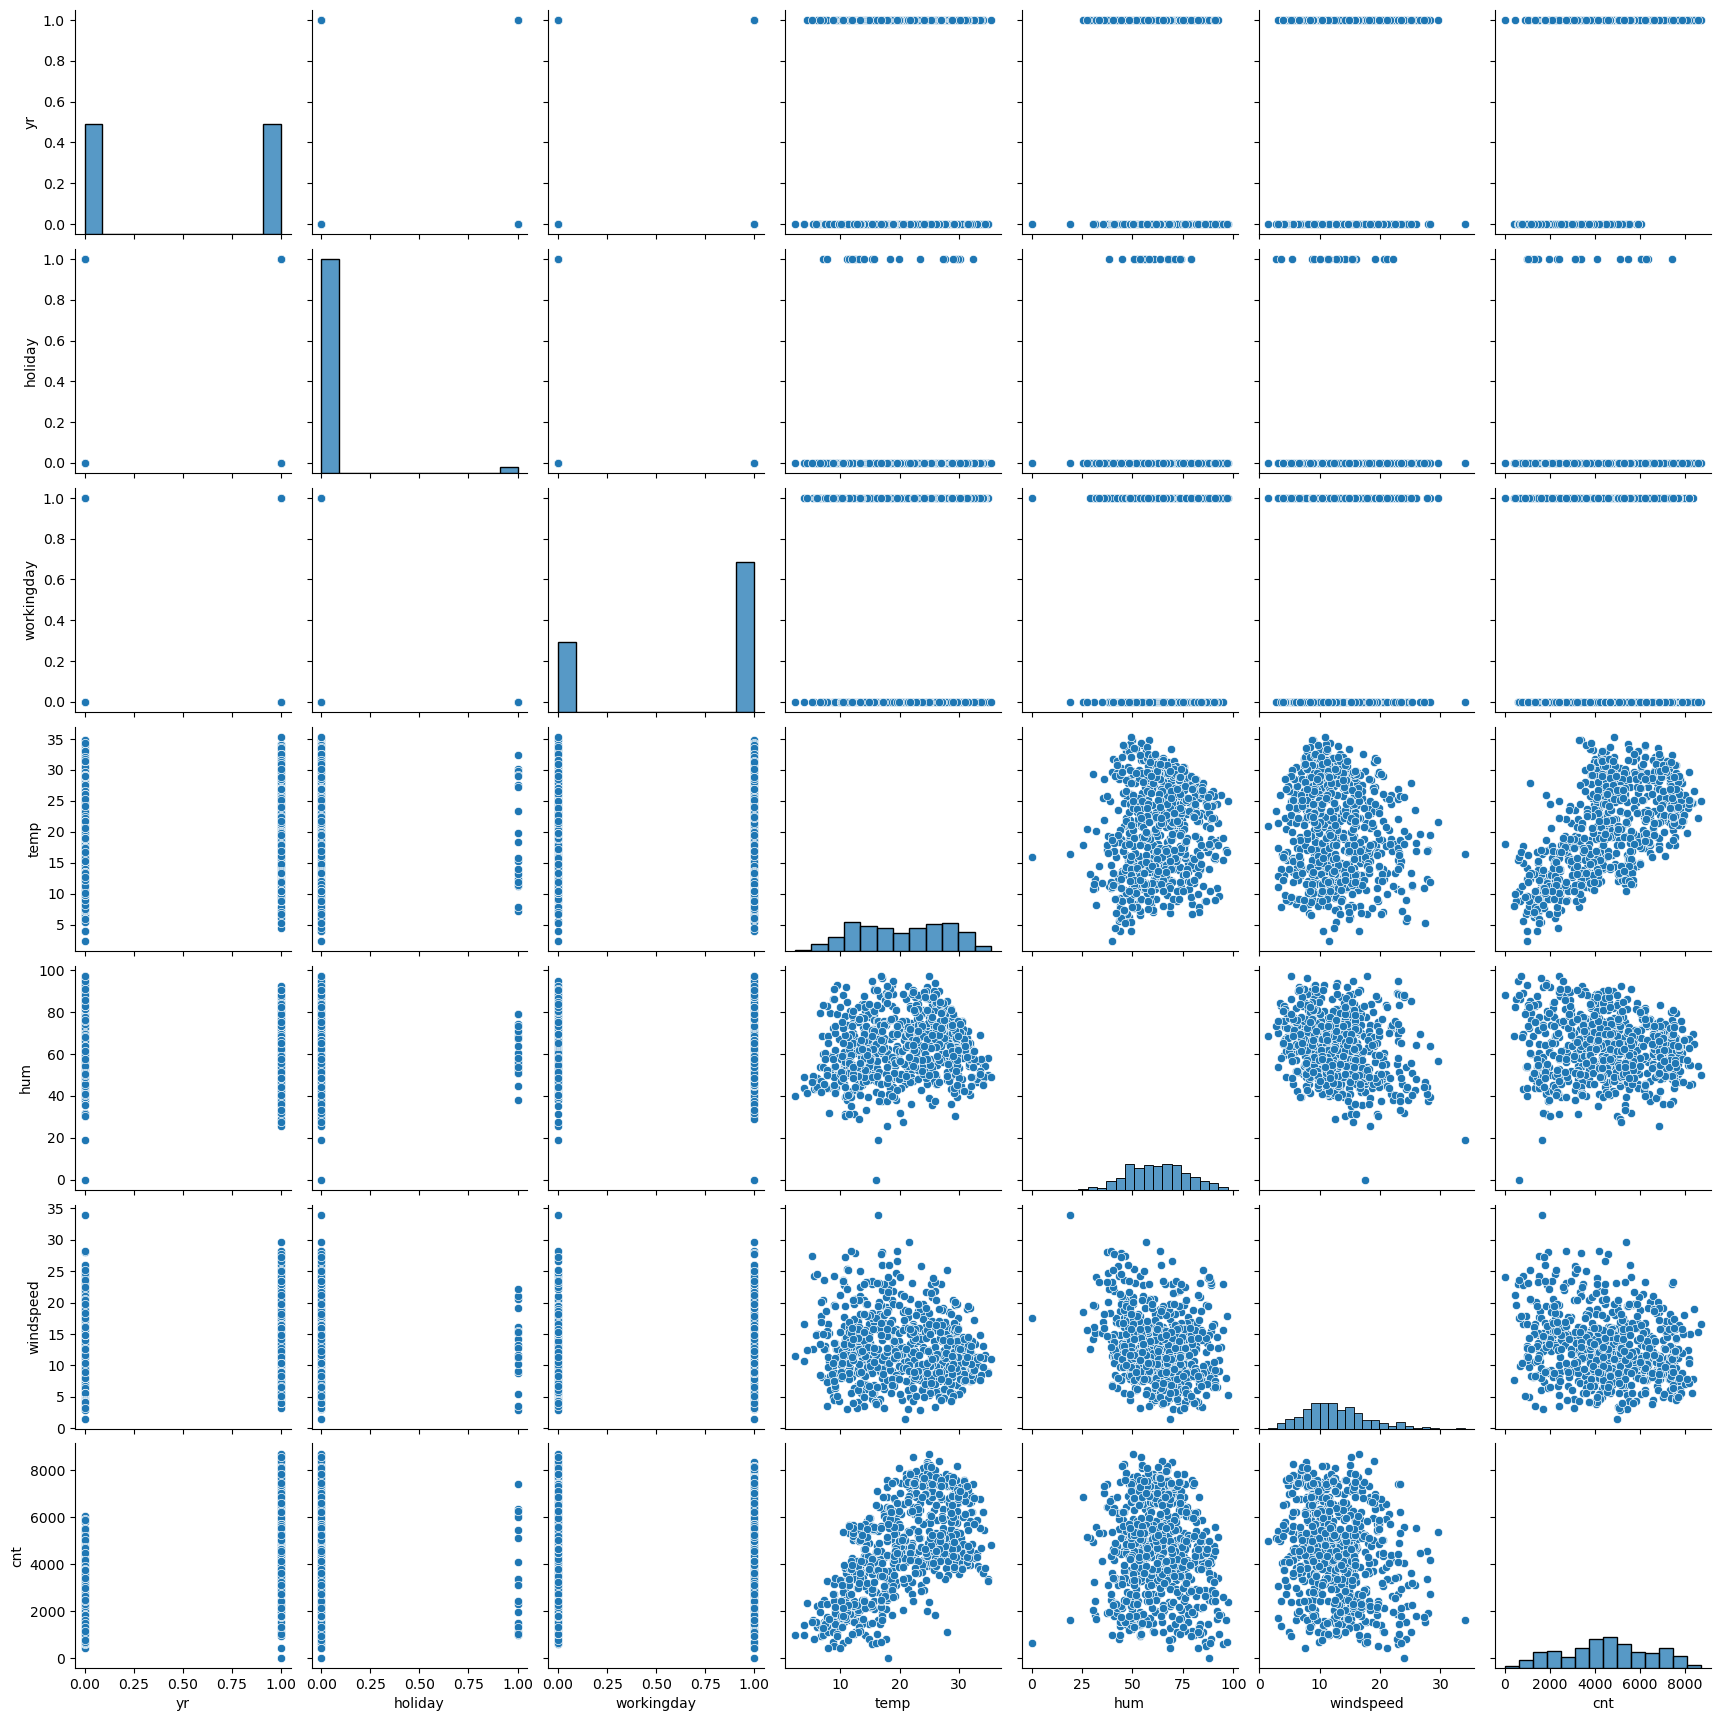

In [14]:
#visualizing numerical variables

sns.pairplot(bike_clean)
plt.show()


## some indications
above graphs show that there is strong correlation between temp and count
other columns has some correlation with cnt but not very strong

## Visualizing numerical and categorical variables
to visualize we also need to see, if we need to create any dummy variable to have better visualization around it.

If we look into the data, we can see that there can be more dummy variable need to be added specially for weathersit and month

we can add derived columns for weahtersit,season,mnth,weekday


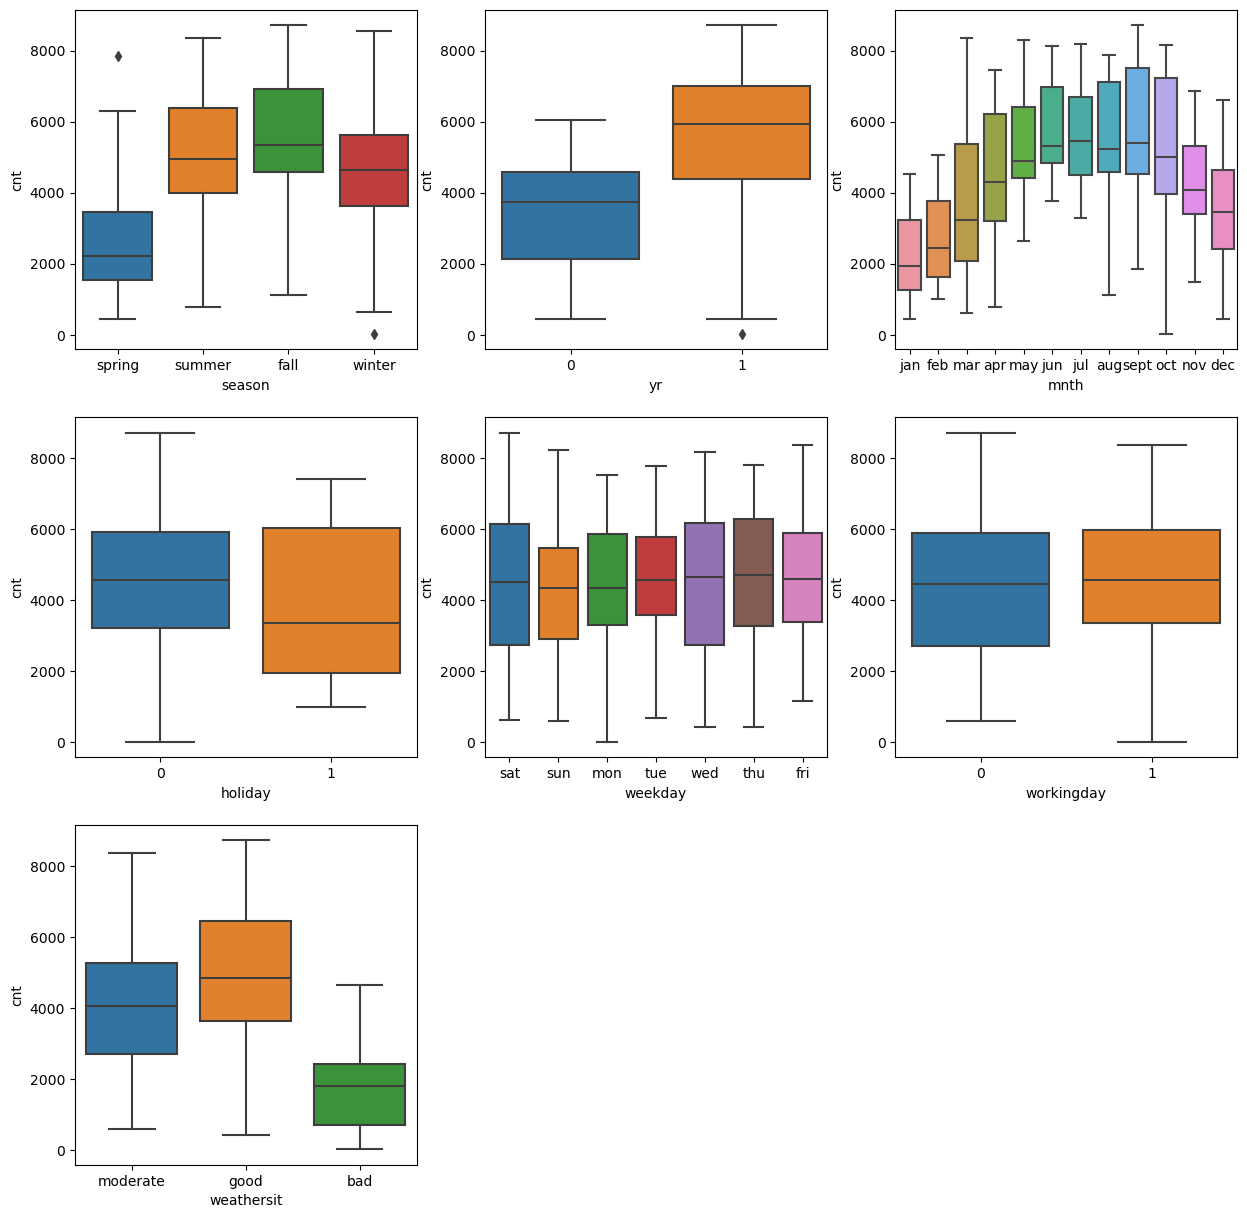

In [15]:
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
plt.figure(figsize=(15, 15))
for i in enumerate(cat_vars):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data=bike_clean, x=i[1], y='cnt')
plt.show()

#### _`Patterns and Insights`_:
    Here few indicators that explain some pattern about the data

    1. Season: bike demand increases in fall season.
    2. Demand in months increasing and decreasing as per the seasons they belong to, which means there is a significant correlation present between mnth and season and which is very obvious. As months represent more granularity to seasons.
    3. On holidays, it seems a strage behavior that demand decreasing. This may be becasue people are making visits to freinds and families during holiday or going out for vacation.
    4. No significant difference for weekdays as well weekend and non weekends days.
    5. Demand is highest for good weather and which also relates to summer and fall season.
    

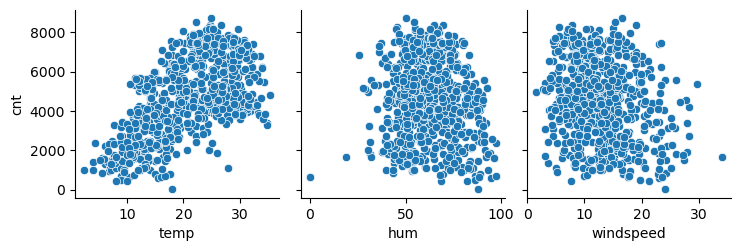

In [16]:
sns.pairplot(
    bike_clean,
    x_vars=["temp", "hum", "windspeed"],
    y_vars=["cnt"],
)
plt.show()

### patterns and insights
we can see below patterns
1. Cnt increasing when temp is increasing, have a good correlation.
2. for hum there is not a very good relation, but there is a pattern when humidity is near 50 the demand increases and scatters between 50 to 100.
3. Data is more scattered around windspeed, only inference we can make is when windwspeed is going beyond 30 no one is going for any bike ride.

In [17]:
#checking multicolienarity
bike_clean.corr()

,yr,holiday,workingday,temp,hum,windspeed,cnt
yr,1.000000,0.008195,-0.002945,0.048789,-0.112547,-0.011624,0.569728
holiday,0.008195,1.000000,-0.252948,-0.028764,-0.015662,0.006257,-0.068764
workingday,-0.002945,-0.252948,1.000000,0.053470,0.023202,-0.018666,0.062542
temp,0.048789,-0.028764,0.053470,1.000000,0.128565,-0.158186,0.627044
hum,-0.112547,-0.015662,0.023202,0.128565,1.000000,-0.248506,-0.098543
windspeed,-0.011624,0.006257,-0.018666,-0.158186,-0.248506,1.000000,-0.235132
cnt,0.569728,-0.068764,0.062542,0.627044,-0.098543,-0.235132,1.000000


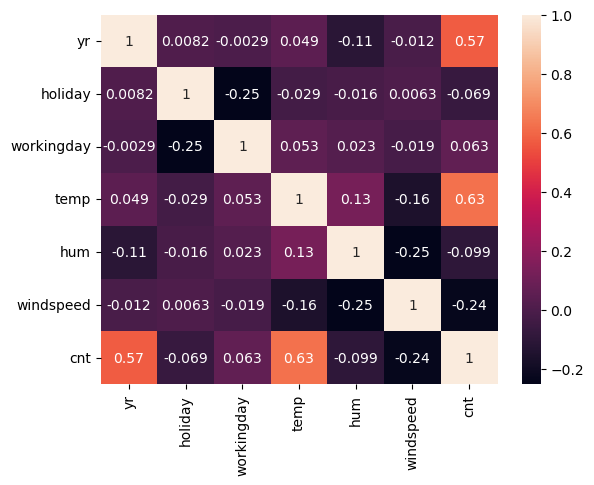

In [18]:
sns.heatmap(bike_clean.corr(), annot = True)
plt.show()

## data clean up and preparation for modeling

### creating dummy variables

In [19]:
bike_clean = pd.get_dummies(data=bike_clean,columns=["season","mnth","weekday"],drop_first=True)
bike_clean = pd.get_dummies(data=bike_clean,columns=["weathersit"])

In [20]:
bike_clean.shape

(730, 30)

## Building Model

### Build train and test sets 

In [21]:
#y to contain only target variable
y=bike_clean.pop('cnt')

#X is all remainign variable also our independent variables
X=bike_clean

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
#shape of train and test data to see the distribution
print(X_train.shape)
print(X_test.shape)

(511, 29)
(219, 29)


In [23]:
#check stats info before scaling
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,...,511.00000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.520548,0.027397,0.669276,20.550310,63.482145,12.598001,0.230920,0.258317,0.250489,0.074364,...,0.09002,0.148728,0.150685,0.152642,0.146771,0.131115,0.140900,0.029354,0.624266,0.346380
std,0.500067,0.163398,0.470935,7.476797,13.939855,4.965253,0.421834,0.438138,0.433719,0.262619,...,0.28649,0.356169,0.358092,0.359994,0.354224,0.337857,0.348259,0.168963,0.484786,0.476282
min,0.000000,0.000000,0.000000,2.424346,0.000000,1.500244,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.079626,52.848700,9.041918,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,21.354153,64.041700,11.791732,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,26.940424,73.458300,15.583497,0.000000,1.000000,0.500000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,35.328347,97.041700,28.250014,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# Let us scale continuous variables
num_vars = ['temp','hum','windspeed']

#Use Normalized scaler to scale
scaler = MinMaxScaler()

#Fit and transform training set only
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [25]:
#check stats info after scaling
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,season_spring,season_summer,season_winter,mnth_aug,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,...,511.00000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.520548,0.027397,0.669276,0.550874,0.654174,0.414873,0.230920,0.258317,0.250489,0.074364,...,0.09002,0.148728,0.150685,0.152642,0.146771,0.131115,0.140900,0.029354,0.624266,0.346380
std,0.500067,0.163398,0.470935,0.227231,0.143648,0.185619,0.421834,0.438138,0.433719,0.262619,...,0.28649,0.356169,0.358092,0.359994,0.354224,0.337857,0.348259,0.168963,0.484786,0.476282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354221,0.544598,0.281934,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.575304,0.659940,0.384732,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.745079,0.756977,0.526481,0.000000,1.000000,0.500000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# function to build model
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [27]:
#Function to calculate VIFs and print  
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [28]:
# Build a Lienar Regression model
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [29]:
# reduce number of features to 15
rfe = RFE(lr,n_features_to_select=15)

rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [30]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 6),
 ('season_winter', False, 4),
 ('mnth_aug', False, 12),
 ('mnth_dec', False, 14),
 ('mnth_feb', False, 5),
 ('mnth_jan', False, 15),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 13),
 ('mnth_mar', False, 2),
 ('mnth_may', False, 3),
 ('mnth_nov', False, 7),
 ('mnth_oct', True, 1),
 ('mnth_sept', True, 1),
 ('weekday_mon', False, 9),
 ('weekday_sat', True, 1),
 ('weekday_sun', True, 1),
 ('weekday_thu', False, 11),
 ('weekday_tue', False, 8),
 ('weekday_wed', False, 10),
 ('weathersit_bad', True, 1),
 ('weathersit_good', True, 1),
 ('weathersit_moderate', True, 1)]

In [31]:
#Selected columns for Model 1 - all columns selected by RFE
cols = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'mnth_jan', 'mnth_jul', 'mnth_sept', 'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']

lr = build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     167.9
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          4.52e-183
Time:                        23:59:55   Log-Likelihood:                -4131.1
No. Observations:                 511   AIC:                             8294.
Df Residuals:                     495   BIC:                             8362.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2373.1199    

In [32]:
#model 2
# Dropping the variable mnth_jan as they have high p-value
cols = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'mnth_jul', 'mnth_sept', 'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']
lr = build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     180.2
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.59e-184
Time:                        23:59:56   Log-Likelihood:                -4131.2
No. Observations:                 511   AIC:                             8292.
Df Residuals:                     496   BIC:                             8356.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2357.7484    

In [33]:
#model 3
# Dropping the month variables as they already getting considered with seasons
cols = ['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter',  'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']
lr = build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     192.4
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.30e-178
Time:                        23:59:57   Log-Likelihood:                -4150.9
No. Observations:                 511   AIC:                             8328.
Df Residuals:                     498   BIC:                             8383.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2361.6850    

In [34]:
# model 4
# Dropping the hum variables as it has very high p value
cols = ['yr', 'holiday', 'workingday', 'temp',  'windspeed', 'season_spring',
       'season_summer', 'season_winter',  'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']
build_model(cols) 
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     205.0
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.85e-177
Time:                        23:59:58   Log-Likelihood:                -4156.2
No. Observations:                 511   AIC:                             8336.
Df Residuals:                     499   BIC:                             8387.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1693.6138    

In [35]:
# model 5
# Dropping the holiday variable as it has high negative coefficient 
cols = ['yr',  'workingday', 'temp',  'windspeed', 'season_spring',
       'season_summer', 'season_winter',  'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']
lr = build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     224.4
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          1.04e-177
Time:                        00:00:00   Log-Likelihood:                -4157.6
No. Observations:                 511   AIC:                             8337.
Df Residuals:                     500   BIC:                             8384.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1628.2375    

In [36]:
# model 6
# Dropping the workingday and weekday_sat variables, because as per the boxplots it does not make any significane and there is no vaiance
# in graph as per workinday
cols = ['yr',   'temp',  'windspeed', 'season_spring',
       'season_summer', 'season_winter',  
       'weathersit_bad', 'weathersit_moderate']
lr = build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     269.2
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          3.62e-176
Time:                        00:00:01   Log-Likelihood:                -4167.0
No. Observations:                 511   AIC:                             8352.
Df Residuals:                     502   BIC:                             8390.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1954.8314    

In [37]:
# model 7
# Dropping the windspeed variable as this also got considered in season 
cols = ['yr',   'temp',   'season_spring',
       'season_summer', 'season_winter',  
       'weathersit_bad', 'weathersit_moderate']
lr = build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     297.4
Date:                Thu, 16 Mar 2023   Prob (F-statistic):          2.93e-174
Time:                        00:00:04   Log-Likelihood:                -4174.4
No. Observations:                 511   AIC:                             8365.
Df Residuals:                     503   BIC:                             8399.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1536.1563    

### Now as the p-value has come good the model looks good to go

## Model evaluation

In [41]:
#Build a model with all columns to select features automatically
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1


In [42]:
# model 7
# Dropping the windspeed variable as this also got considered in season 
cols = ['yr',   'temp',   'season_spring',
       'season_summer', 'season_winter',  
       'weathersit_bad', 'weathersit_moderate']
lr = build_model_sk(X_train[cols],y_train)
print(lr.intercept_,lr.coef_)

1536.1562981058337 [ 1999.76433067  4067.84258607  -975.27592042   260.15539704
   720.05374716 -2272.23562896  -637.17920289]


In [43]:
y_train_pred = lr.predict(X_train[cols])

In [44]:
#Plot a histogram of the error terms
def plot_res_dist(act, pred):
    sns.distplot(act-pred)
    plt.title('Error Terms')
    plt.xlabel('Errors')

##### Insight:

- This model i.e. Model 7, looks good, as there seems to be VERY LOW Multicollinearity between the predictors and the p-values for all the predictors seems to be significant. For now, we will consider this as our final model.
- There seems a slight P-Value in the 'Holiday' variable but it is well below the P-Value limit i.e. 0.05, therefore it is safe to keep it for further prediction analysis.

### _`Conclusion`_
Significant variables to predict the demand for shared bikes
- temp
- hum
- windspeed
- Season (summer,winter)
- Year 
- weathersit